In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
#from astropy.utils.console import ProgressBar

In [2]:
%matplotlib inline
%config Completer.use_jedi = False

### Setup for test
First we just want to define the directory where our data is stored, then the rms noise value of the image (usually defined from residuals) and the initial dendrogram parameters. The minimum value and minimum significance parameters are scaled by the rms noise, so their is some degeneracy in the choice of the RMS vs the dendrogram parameters as this is set up. 

In [3]:
##############################################################
### Some basic setup here:

### this directory should point to the data you wish to use
directory = '/Users/hph/astrophys/almagal_dendrogram/synth_142185TM2+7M/'
### the RMS here has been guesstimated from the sample ALMAGAL field. 
rms=0.0004

### This is the minimum value of the dendrogram (see https://dendrograms.readthedocs.io/en/stable/algorithm.html)
dend_min_v = 6 
### this is the minimum significance '' (see https://dendrograms.readthedocs.io/en/stable/algorithm.html)
dend_min_d = 3
### this is the minimum number of pixels, same link for deets
dend_min_pix = 30


In [4]:
################################
### open data and make a mask 
sources = fits.open(directory+'142185TM2+7M_AggLineFreeBW.im.image_0.80000_sources.fits')
sdata = sources[0].data[0,0,:,:]
smask = np.zeros_like(sdata)
print(sdata.shape)
smask[sdata>np.mean(sdata)]=1



(448, 448)


In [5]:
################################################
### run the initial dendrogram! woohoo!
almasim = fits.open(directory+'142185TM2+7M_AggLineFreeBW.im.image_0.20000_simul.fits')
data = almasim[0].data[0,0,:,:]
HeaderMod = almasim[0].header
mywcs = wcs.WCS(HeaderMod)
print( "Running dendrogram...")
dend = astrodendro.Dendrogram.compute(data, min_value=float(dend_min_v)*rms, min_delta=float(dend_min_d)*rms,
                                      min_npix=dend_min_pix,
                                      wcs=mywcs)

Running dendrogram...


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [10]:
########################################################
### Now create a "catalog" from the dendrogram output

### here we define the pixel size:
PixelAreaArcsec = 3600. * abs(HeaderMod['CDELT1']) * 3600. * abs(HeaderMod['CDELT2'])

###initialize an empty array for the metadata, and fill initial quantities
Metadata = {}
### Define the pixel units in the image input to the dendrogram:
Metadata['data_unit'] = u.Jy/u.beam
### define the pixel size (on one side):
Metadata['spatial_scale'] =  PixelAreaArcsec**0.5 * u.arcsec
### define the beam parameters (since pixel units are jy/beam)
Metadata['beam_major'] = HeaderMod['BMAJ']*u.deg
Metadata['beam_minor'] = HeaderMod['BMIN']*u.deg
beam_omega_deg2 = HeaderMod['BMAJ']*HeaderMod['BMIN']*np.pi/(4*np.log(2))
### convert beam parameters (if needed):
pix_area_deg2 = abs(HeaderMod['CDELT1']) * abs(HeaderMod['CDELT2'])
pix_per_beam = beam_omega_deg2/pix_area_deg2

### this next line runs the catalog characterization, defining the catalog.
catalog = astrodendro.pp_catalog(dend, Metadata)
### conveniently rename columns:
catalog.rename_column('_idx', 'index')
catalog.rename_column('flux', 'flux_integrated')

### define some new keys for the catalog dictionary
### 'is_leaf': boolean values for whether a structure is a leaf or not
### 'peak_cont_flux': the peak continuum flux (image units)
### 'min_cont_flux': the minimum continuum flux (image units)
### 'mean_cont_flux': the mean continuum flux (image units)
### 'npix': number of pixels
### 'mask': the integer mask value for the leaf
keys = ['is_leaf', 'peak_cont_flux', 'min_cont_flux', 'mean_cont_flux','npix','mask']
columns = {k:[] for k in (keys)}

### loops through all the dendrogram structures 
for ii, row in enumerate(catalog):
    structure = dend[row['index']]
    assert structure.idx == row['index'] == ii
    dend_inds = structure.indices()
    ### update catalog dictionary values for the keys
    columns['is_leaf'].append(structure.is_leaf)
    peakflux = data[dend_inds].max()
    minflux = data[dend_inds].min()
    numpix = np.shape(dend_inds)[1]
    columns['peak_cont_flux'].append(peakflux)
    columns['min_cont_flux'].append(data[dend_inds].min())
    columns['mean_cont_flux'].append(data[dend_inds].mean())
    columns['npix'].append(numpix)
    columns['mask'].append(0)
    
### actually add the catalog key/columns now.
for k in columns:
        if k not in catalog.keys():
            catalog.add_column(Column(name=k, data=columns[k]))

### generate a mask for the leaves.
cat_mask = (catalog['is_leaf'])
### leafcat is the catalog of JUST THE LEAVES (this is probably what you'll want to use for analysis)
leafcat = catalog[cat_mask]
mask = dend.index_map.copy()

### give each of the mask leaves 
for ii in range(len(catalog)):
    if ii not in leafcat['index']:
        mask[mask == ii] = -1

### generate a fits HDU in case you want to save your data file.
outf = fits.PrimaryHDU(data=mask, header=HeaderMod)

Computing catalog for 21 structures

[=>                                       ] 4%
[===>                                     ] 9%
[=====>                                   ] 14%
[=======>                                 ] 19%
[=========>                               ] 23%
[===========>                             ] 28%
[=============>                           ] 33%
[===============>                         ] 38%
[=================>                       ] 42%
[===================>                     ] 47%
[====================>                    ] 52%
[======================>                  ] 57%
[========================>                ] 61%
[==========================>              ] 66%
[============================>            ] 71%
[==============================>          ] 76%
[================================>        ] 80%
[==================================>      ] 85%
[====================================>    ] 90%
[======================================>  ] 95%
[====

/Users/hph/anaconda3/envs/astrop3/lib/python3.9/site-packages/astrodendro/plot.py:159: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(mask, levels=[0.5], **kwargs)


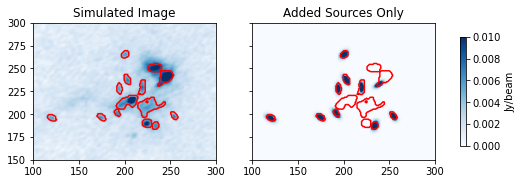

In [8]:
p = dend.plotter()

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(9,4), sharey=True)
ax = axes[0]
im = ax.imshow(data, origin='lower', interpolation='nearest',
          cmap=plt.cm.Blues, vmax=0.01)
ax.set_xlim(100,300)
ax.set_ylim(150,300)
ax.set_title('Simulated Image')
for leaf in dend.leaves:

    p.plot_contour(ax, structure=leaf, lw=3, colors='red')
    
ax = axes[1]
im = ax.imshow(sdata, origin='lower', interpolation='nearest',
          cmap=plt.cm.Blues, vmax=0.01)
ax.set_xlim(100,300)
ax.set_ylim(150,300)
ax.set_title('Added Sources Only')

fig.subplots_adjust(hspace=0)

cbar = plt.colorbar(im,ax = axes,shrink=0.5)
cbar.set_label('Jy/beam')

for leaf in dend.leaves:

    p.plot_contour(ax, structure=leaf, lw=3, colors='red')